More recent models, such as TSMixer, TFT and NHITS achieve better accuracy than LSTM in most settings.

In [1]:
!pip install neuralforecast ray[tune] pytorch-lightning utilsforecast matplotlib pandas mlforecast window_ops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set file paths
csv_path = '/content/drive/MyDrive/airkaz/selected_sensors2_cleaned.csv'
pipeline_path = '/content/drive/MyDrive/airkaz/MLForecastPipeline.py'

# Import pipeline module
import sys
sys.path.append('/content/drive/MyDrive/airkaz/')
from MLForecastPipeline import *

# Load CSV
import pandas as pd
selected_sensors_df = pd.read_csv(csv_path, index_col=0)


In [5]:
import logging
import pandas as pd
from ray import tune
from neuralforecast import NeuralForecast
from neuralforecast.auto import (
    AutoNHITS, AutoNBEATS, AutoNBEATSx, AutoTFT, AutoVanillaTransformer,
    AutoInformer, AutoAutoformer, AutoFEDformer, AutoPatchTST, AutoLSTM, AutoGRU,
    AutoRNN, AutoDilatedRNN, AutoTCN, AutoMLP, AutoMLPMultivariate, AutoDLinear,
    AutoNLinear, AutoTimeXer, AutoTSMixer, AutoTSMixerx, AutoTimeMixer,
    AutoTimesNet, AutoiTransformer, AutoSOFTS, AutoStemGNN, AutoBiTCN,
    AutoDeepAR, AutoDeepNPTS, AutoHINT, AutoKAN
)
from neuralforecast.utils import AirPassengersDF
from utilsforecast.plotting import plot_series

# Suppress unnecessary logging
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

In [6]:
scenarios_sensors = {
    # 0: 1, 4372603
    # "0_12M_train_7M_test": {"train_start": "2017-03-25", "train_end": "2018-03-25", "test_start": "2018-03-26", "test_end": "2018-10-10"},
    '2': {
        "26M_train":  {"train_start": "2017-04-01", "train_end": "2019-06-01"},
        "24M_train":  {"train_start": "2017-04-01", "train_end": "2019-04-01"},
        "22M_train":  {"train_start": "2017-04-01", "train_end": "2019-02-01"},
        "20M_train":  {"train_start": "2017-04-01", "train_end": "2018-12-01"},
        "18M_train":  {"train_start": "2017-04-01", "train_end": "2018-10-01"},
        "12M_train":  {"train_start": "2017-04-01", "train_end": "2018-04-01"},
        "10M_train":  {"train_start": "2017-04-01", "train_end": "2018-01-25"},
        "8M_train":   {"train_start": "2017-04-01", "train_end": "2017-10-25"},

        # Non-Heating Periods
        # "NH_3M_train":  {"train_start": "2017-04-15", "train_end": "2017-07-15"},
        # "NH_4M_train":  {"train_start": "2017-04-15", "train_end": "2017-08-15"},
        # "NH_2M_train":  {"train_start": "2017-04-15", "train_end": "2017-06-15"},
        # "NH_1M_train":  {"train_start": "2017-04-15", "train_end": "2017-05-15"},
        # "NH_15D_train": {"train_start": "2017-04-15", "train_end": "2017-04-30"},
        # "NH_feb_2M_train": {"train_start": "2017-02-15", "train_end": "2017-04-15"},
        # "NH_feb_1M_train": {"train_start": "2017-02-15", "train_end": "2017-04-15"},
        # "NH_mar_2M_train": {"train_start": "2017-03-15", "train_end": "2017-05-15"},
        # "NH_mar_1M_train": {"train_start": "2017-03-15", "train_end": "2017-04-15"},

        # # Heating Periods
        # "H_5M_train":     {"train_start": "2017-06-01", "train_end": "2017-11-01"},
        # "H_3M_jul_train": {"train_start": "2017-07-01", "train_end": "2017-10-10"},
        # "H_3M_sep_train": {"train_start": "2017-09-01", "train_end": "2017-12-10"},
        # "H_3M_nov_train": {"train_start": "2017-11-01", "train_end": "2018-02-10"},
        },
}
scenarios_sensors['5'] = scenarios_sensors['2'].copy()
scenarios_sensors['6'] = scenarios_sensors['2'].copy()

def split_data(df, scenario, date_col="ds"):
    """Extracts train and test data based on train end date."""
    train_data = df[df[date_col] <= scenario['train_end']]
    test_start = pd.to_datetime(scenario['train_end']) + pd.Timedelta(days=1)
    test_data = df[df[date_col] >= test_start]
    return train_data, test_data

from joblib import Parallel, delayed
import time
# from MLForecastPipeline import *

auto_models = {
    "AutoNHITS": AutoNHITS, "AutoNBEATS": AutoNBEATS, "AutoNBEATSx": AutoNBEATSx,
    "AutoTFT": AutoTFT, "AutoVanillaTransformer": AutoVanillaTransformer,
    "AutoInformer": AutoInformer, "AutoAutoformer": AutoAutoformer, "AutoFEDformer": AutoFEDformer,
    "AutoPatchTST": AutoPatchTST, "AutoLSTM": AutoLSTM, "AutoGRU": AutoGRU,
    "AutoRNN": AutoRNN, "AutoDilatedRNN": AutoDilatedRNN, "AutoTCN": AutoTCN,
    "AutoMLP": AutoMLP, "AutoMLPMultivariate": AutoMLPMultivariate, "AutoDLinear": AutoDLinear,
    "AutoNLinear": AutoNLinear, "AutoTimeXer": AutoTimeXer, "AutoTSMixer": AutoTSMixer,
    "AutoTSMixerx": AutoTSMixerx, "AutoTimeMixer": AutoTimeMixer,
    "AutoTimesNet": AutoTimesNet, "AutoiTransformer": AutoiTransformer, "AutoSOFTS": AutoSOFTS,
    "AutoStemGNN": AutoStemGNN, "AutoBiTCN": AutoBiTCN, "AutoDeepAR": AutoDeepAR,
    "AutoDeepNPTS": AutoDeepNPTS, "AutoKAN": AutoKAN,
    "AutoHINT": AutoHINT
}

# Function to determine horizon for a single scenario
def determine_scenario_horizon(scenario):
    """Determine the forecast horizon based on the test period length of a specific scenario."""
    train_end = pd.to_datetime(scenario['train_end'])
    test_start = train_end + pd.Timedelta(days=1)
    test_length = (pd.to_datetime(scenario.get('test_end', test_start)) - test_start).days
    return test_length

# Function to create models dynamically for each scenario
def get_auto_model(model_cls, horizon):
    """Dynamically initialize models with scenario-specific horizons."""
    config = model_cls.get_default_config(h=horizon, backend="ray")
    config["random_seed"] = tune.randint(1, 10)
    return model_cls(h=horizon, config=config, backend='ray', num_samples=3)

# Function to process each scenario with its specific horizon
def process_scenario(sensor_name, scenario_name, scenario, selected_sensors_df, models):
    """Process each scenario independently with a dynamically set horizon."""
    print(f'Processing: {sensor_name}_{scenario_name}')

    formatted_df = format_df_to_mlforecast(selected_sensors_df[['full_date', sensor_name]], 'full_date', sensor_name, unique_id=sensor_name)
    formatted_df = formatted_df[['ds', 'y', 'unique_id']]

    train_df, test_df = split_data(formatted_df, scenario)

    scenario_horizon = determine_scenario_horizon(scenario)

    scenario_models = {name: get_auto_model(model_cls, scenario_horizon) for name, model_cls in auto_models.items()}

    results = evaluate_models_nfcst(train_df, test_df, scenario_models)
    save_results(results, f"results/run_10/{sensor_name}_{scenario_name}.csv")

    return results

def run_all_scenarios_parallel(scenarios_sensors, selected_sensors_df):
    """
    Run all scenarios in parallel, ensuring each scenario gets its own horizon-based models.
    """
    results = Parallel(n_jobs=12)(
        delayed(process_scenario)(
            sensor_name, scenario_name, scenario, selected_sensors_df
        )
        for sensor_name, scenarios in scenarios_sensors.items()
        for scenario_name, scenario in scenarios.items()
    )

    return results



In [58]:
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAPE

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from neuralforecast.auto import AutoNHITS
from neuralforecast.timecore import TimeSeriesDataset
import optuna

# Load and prepare data
df_path = "/mnt/data/selected_sensors2_cleaned.csv"
df = pd.read_csv(df_path, index_col=0)
df = df.rename(columns={"full_date": "ds", "2": "y"})
df["ds"] = pd.to_datetime(df["ds"])
df["unique_id"] = "sensor_2"

# Split data
scenario = {"train_start": "2017-04-01", "train_end": "2019-04-01"}
train_df = df[(df["ds"] >= scenario["train_start"]) & (df["ds"] <= scenario["train_end"])]
test_df = df[df["ds"] > scenario["train_end"]]

# Convert to TimeSeriesDataset
train_dataset = TimeSeriesDataset.from_dataframe(train_df, freq="D", sort_df=True)
test_dataset = TimeSeriesDataset.from_dataframe(test_df, freq="D", sort_df=True)

# Define a custom config function for Optuna
def nhits_config(trial: optuna.Trial):
    return {
        "input_size": trial.suggest_int("input_size", 60, 180),
        "n_pool_kernel_size": trial.suggest_categorical("n_pool_kernel_size", [[2, 2, 2], [4, 2, 1]]),
        "n_freq_downsample": trial.suggest_categorical("n_freq_downsample", [[24, 12, 1], [7, 2, 1]]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-2),
        "max_steps": trial.suggest_int("max_steps", 100, 300),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
        "windows_batch_size": trial.suggest_categorical("windows_batch_size", [64, 128, 256]),
        "random_seed": trial.suggest_int("random_seed", 1, 10),
    }

# Train model with tuning
h = len(test_df)
model = AutoNHITS(h=h, config=nhits_config, num_samples=10, backend="optuna")
model.fit(dataset=train_dataset)


In [109]:
df = pd.read_csv('/content/drive/MyDrive/airkaz/selected_sensors2_cleaned.csv', index_col=0)

# 4. Prepare one sensor column and rename for compatibility
df = df.rename(columns={'full_date': 'ds', '2': 'y'})
df['ds'] = pd.to_datetime(df['ds'])
df['unique_id'] = 'sensor_2'

scenario = {"train_start": "2017-04-01", "train_end": "2019-04-01"}
train_df, test_df = split_data(df[['ds', 'y', 'unique_id']], scenario)

import optuna
def nhits_config(trial: optuna.Trial):
    return {
        "input_size": trial.suggest_int("input_size", 60, 600),
        "n_pool_kernel_size": trial.suggest_categorical("n_pool_kernel_size", [
                (2, 2, 2),
                (4, 2, 1),
                (8, 4, 1),
                (3, 2, 1),
            ]),
        "n_freq_downsample": trial.suggest_categorical("n_freq_downsample", [
                (24, 12, 1),  # daily → weekly → monthly
                (7, 2, 1),    # weekly → shorter
                (30, 7, 1),   # monthly → weekly
                (365, 30, 7), # yearly → monthly → weekly
            ]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "max_steps": trial.suggest_int("max_steps", 100, 200),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
        "windows_batch_size": trial.suggest_categorical("windows_batch_size", [64, 128, 256]),
        "random_seed": trial.suggest_int("random_seed", 1, 10),
        # "start_padding_enabled": True,
        "dropout_prob_theta": trial.suggest_float("dropout", 0.1, 0.5),
        # "verbose":3
    }

def nbeatsx_config(trial):
    stack_types = ["seasonality", "trend"]
    n_blocks = trial.suggest_int("n_blocks_per_stack", 2, 4)

    # Define shared MLP structure per stack (e.g., 2 hidden layers)
    units = trial.suggest_categorical("units", [128, 256, 512])
    mlp_units = [[units, units] for _ in stack_types]

    return {
        "input_size": trial.suggest_int("input_size", 120, 400),
        "stack_types": stack_types,
        "n_blocks": [n_blocks] * len(stack_types),
        "mlp_units": mlp_units,  # ✅ now a list of lists
        "dropout_prob_theta": trial.suggest_float("dropout", 0.05, 0.35),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "max_steps": trial.suggest_int("max_steps", 100, 500),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),
        "windows_batch_size": trial.suggest_categorical("windows_batch_size", [128, 256, 300, 352]),
        "random_seed": trial.suggest_int("random_seed", 1, 10),
        "start_padding_enabled": True,
        "shared_weights": False
    }



def fedformer_config(trial):
    return {
        "input_size": trial.suggest_int("input_size", 180, 400),  # year-level seasonality
        "dropout": trial.suggest_float("dropout", 0.1, 0.3),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "max_steps": trial.suggest_int("max_steps", 200, 500),
        # "d_model": trial.suggest_categorical("d_model", [128, 256, 512]),
        # "n_heads": trial.suggest_categorical("n_heads", [2, 4, 8]),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32]),
        "windows_batch_size": trial.suggest_categorical("windows_batch_size", [64, 128]),
        "start_padding_enabled": True,
        "random_seed": trial.suggest_int("random_seed", 1, 10),
    }

def autoformer_config(trial):
    return {
        "input_size": trial.suggest_int("input_size", 180, 365),
        "dropout": trial.suggest_float("dropout", 0.1, 0.3),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "max_steps": trial.suggest_int("max_steps", 200, 500),
        # "d_model": trial.suggest_categorical("d_model", [128, 256]),
        # "n_heads": trial.suggest_categorical("n_heads", [2, 4]),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32]),
        "windows_batch_size": trial.suggest_categorical("windows_batch_size", [64, 128]),
        "start_padding_enabled": True,
        "random_seed": trial.suggest_int("random_seed", 1, 10),
    }


In [ ]:
# Convert pandas DataFrame to neuralforecast-compatible dataset
train_dataset = TimeSeriesDataset.from_df(train_df)
test_dataset = TimeSeriesDataset.from_df(test_df)

In [ ]:
# model = AutoNHITS(h=len(test_df), config=nhits_config, num_samples=10, backend="optuna", loss=MAPE())
# model.fit(dataset=train_dataset[0])
# forecast_df = model.predict(dataset=test_dataset[0])

[I 2025-03-24 10:46:27,039] A new study created in memory with name: no-name-5e092648-d0dd-4a13-952f-d14533992375
INFO:lightning_fabric.utilities.seed:Seed set to 8


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 10:50:16,556] Trial 0 finished with value: 1.290334701538086 and parameters: {'input_size': 308, 'dropout': 0.2884062221236168, 'learning_rate': 0.005981552085052863, 'max_steps': 396, 'batch_size': 32, 'windows_batch_size': 64, 'random_seed': 8}. Best is trial 0 with value: 1.290334701538086.
INFO:lightning_fabric.utilities.seed:Seed set to 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 10:54:03,040] Trial 1 finished with value: 0.5620738863945007 and parameters: {'input_size': 367, 'dropout': 0.13877874950303437, 'learning_rate': 0.00030831568189393035, 'max_steps': 369, 'batch_size': 16, 'windows_batch_size': 64, 'random_seed': 2}. Best is trial 1 with value: 0.5620738863945007.
INFO:lightning_fabric.utilities.seed:Seed set to 4


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 10:59:19,291] Trial 2 finished with value: 1.112794280052185 and parameters: {'input_size': 339, 'dropout': 0.16436770832593828, 'learning_rate': 0.006500107410037674, 'max_steps': 288, 'batch_size': 16, 'windows_batch_size': 128, 'random_seed': 4}. Best is trial 1 with value: 0.5620738863945007.
INFO:lightning_fabric.utilities.seed:Seed set to 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 11:04:52,095] Trial 3 finished with value: 1.6649800539016724 and parameters: {'input_size': 315, 'dropout': 0.2235512572770178, 'learning_rate': 0.008558160936024633, 'max_steps': 314, 'batch_size': 32, 'windows_batch_size': 128, 'random_seed': 2}. Best is trial 1 with value: 0.5620738863945007.
INFO:lightning_fabric.utilities.seed:Seed set to 9


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 11:08:36,853] Trial 4 finished with value: 0.5790374875068665 and parameters: {'input_size': 399, 'dropout': 0.2761015992667275, 'learning_rate': 0.0006346245770899982, 'max_steps': 354, 'batch_size': 16, 'windows_batch_size': 64, 'random_seed': 9}. Best is trial 1 with value: 0.5620738863945007.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 11:12:48,302] Trial 5 finished with value: 0.5815846920013428 and parameters: {'input_size': 335, 'dropout': 0.15106826895094672, 'learning_rate': 0.0009162248829877366, 'max_steps': 425, 'batch_size': 16, 'windows_batch_size': 64, 'random_seed': 1}. Best is trial 1 with value: 0.5620738863945007.
INFO:lightning_fabric.utilities.seed:Seed set to 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 11:14:38,539] Trial 6 finished with value: 0.5771199464797974 and parameters: {'input_size': 212, 'dropout': 0.27036588812302653, 'learning_rate': 0.005552772189959576, 'max_steps': 217, 'batch_size': 32, 'windows_batch_size': 64, 'random_seed': 10}. Best is trial 1 with value: 0.5620738863945007.
INFO:lightning_fabric.utilities.seed:Seed set to 3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 11:19:53,091] Trial 7 finished with value: 0.5528566837310791 and parameters: {'input_size': 368, 'dropout': 0.2075716849011556, 'learning_rate': 0.00033069730513705475, 'max_steps': 277, 'batch_size': 16, 'windows_batch_size': 128, 'random_seed': 3}. Best is trial 7 with value: 0.5528566837310791.
INFO:lightning_fabric.utilities.seed:Seed set to 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 11:23:11,383] Trial 8 finished with value: 0.4454604685306549 and parameters: {'input_size': 278, 'dropout': 0.299291007775517, 'learning_rate': 0.004176303591122806, 'max_steps': 359, 'batch_size': 16, 'windows_batch_size': 64, 'random_seed': 10}. Best is trial 8 with value: 0.4454604685306549.
INFO:lightning_fabric.utilities.seed:Seed set to 7


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 11:27:01,520] Trial 9 finished with value: 1.5286957025527954 and parameters: {'input_size': 214, 'dropout': 0.2549069840775433, 'learning_rate': 0.00814108688545411, 'max_steps': 452, 'batch_size': 32, 'windows_batch_size': 64, 'random_seed': 7}. Best is trial 8 with value: 0.4454604685306549.
INFO:lightning_fabric.utilities.seed:Seed set to 6


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 11:34:44,783] Trial 10 finished with value: 0.6032636761665344 and parameters: {'input_size': 259, 'dropout': 0.10481237969511882, 'learning_rate': 0.0022386223784901915, 'max_steps': 475, 'batch_size': 16, 'windows_batch_size': 128, 'random_seed': 6}. Best is trial 8 with value: 0.4454604685306549.
INFO:lightning_fabric.utilities.seed:Seed set to 4


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 11:38:56,551] Trial 11 finished with value: 0.5332308411598206 and parameters: {'input_size': 270, 'dropout': 0.21014844270214234, 'learning_rate': 0.00018826033416104092, 'max_steps': 254, 'batch_size': 16, 'windows_batch_size': 128, 'random_seed': 4}. Best is trial 8 with value: 0.4454604685306549.
INFO:lightning_fabric.utilities.seed:Seed set to 5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 11:42:13,909] Trial 12 finished with value: 0.5780790448188782 and parameters: {'input_size': 264, 'dropout': 0.2363577314734899, 'learning_rate': 0.000113416504232553, 'max_steps': 201, 'batch_size': 16, 'windows_batch_size': 128, 'random_seed': 5}. Best is trial 8 with value: 0.4454604685306549.
INFO:lightning_fabric.utilities.seed:Seed set to 5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 11:46:16,243] Trial 13 finished with value: 0.4799433648586273 and parameters: {'input_size': 256, 'dropout': 0.18498693755244944, 'learning_rate': 0.0023670673559308937, 'max_steps': 250, 'batch_size': 16, 'windows_batch_size': 128, 'random_seed': 5}. Best is trial 8 with value: 0.4454604685306549.
INFO:lightning_fabric.utilities.seed:Seed set to 7


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 11:49:06,433] Trial 14 finished with value: 0.5247862935066223 and parameters: {'input_size': 241, 'dropout': 0.17162375472178437, 'learning_rate': 0.002565608100323264, 'max_steps': 323, 'batch_size': 16, 'windows_batch_size': 64, 'random_seed': 7}. Best is trial 8 with value: 0.4454604685306549.
INFO:lightning_fabric.utilities.seed:Seed set to 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 11:54:45,720] Trial 15 finished with value: 0.5698002576828003 and parameters: {'input_size': 191, 'dropout': 0.18700535945181565, 'learning_rate': 0.0024698187448737234, 'max_steps': 389, 'batch_size': 16, 'windows_batch_size': 128, 'random_seed': 10}. Best is trial 8 with value: 0.4454604685306549.
INFO:lightning_fabric.utilities.seed:Seed set to 6


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 11:58:59,926] Trial 16 finished with value: 0.5544121265411377 and parameters: {'input_size': 300, 'dropout': 0.12071131086434922, 'learning_rate': 0.0014960713512832179, 'max_steps': 243, 'batch_size': 16, 'windows_batch_size': 128, 'random_seed': 6}. Best is trial 8 with value: 0.4454604685306549.
INFO:lightning_fabric.utilities.seed:Seed set to 8


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 12:01:48,811] Trial 17 finished with value: 0.49635905027389526 and parameters: {'input_size': 237, 'dropout': 0.2974134216065853, 'learning_rate': 0.00346926135864322, 'max_steps': 325, 'batch_size': 16, 'windows_batch_size': 64, 'random_seed': 8}. Best is trial 8 with value: 0.4454604685306549.
INFO:lightning_fabric.utilities.seed:Seed set to 5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 12:08:49,857] Trial 18 finished with value: 0.4351279139518738 and parameters: {'input_size': 288, 'dropout': 0.24193880872831852, 'learning_rate': 0.0013124086619509766, 'max_steps': 415, 'batch_size': 32, 'windows_batch_size': 128, 'random_seed': 5}. Best is trial 18 with value: 0.4351279139518738.
INFO:lightning_fabric.utilities.seed:Seed set to 8


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 12:13:24,415] Trial 19 finished with value: 0.538347065448761 and parameters: {'input_size': 285, 'dropout': 0.24879127239988055, 'learning_rate': 0.0010901138054825552, 'max_steps': 498, 'batch_size': 32, 'windows_batch_size': 64, 'random_seed': 8}. Best is trial 18 with value: 0.4351279139518738.
INFO:lightning_fabric.utilities.seed:Seed set to 5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

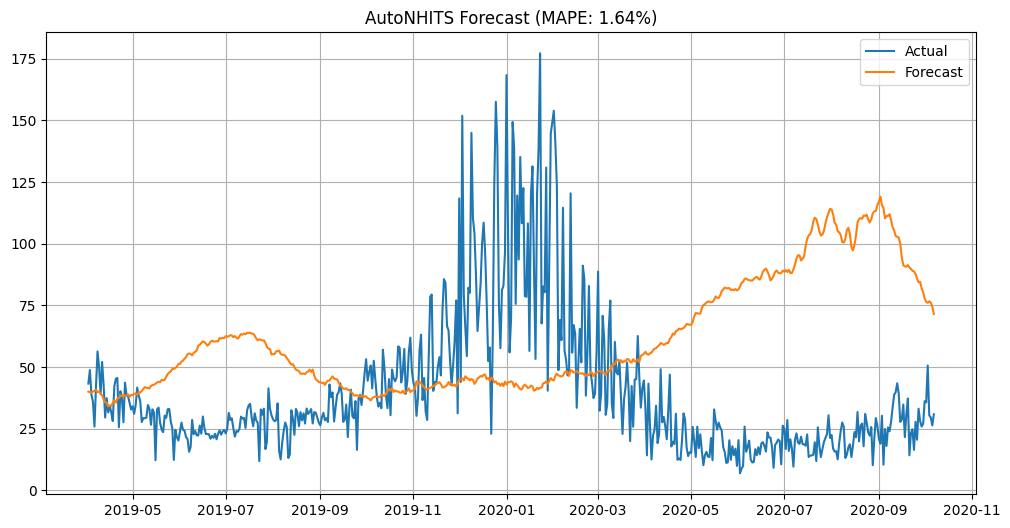

Predicting: |          | 0/? [00:00<?, ?it/s]

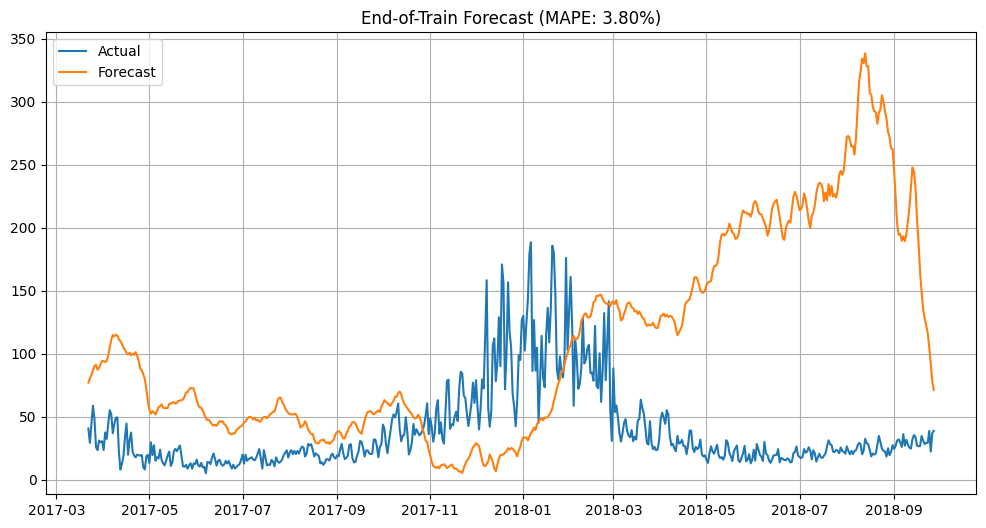

In [108]:
model = AutoFEDformer(h=len(test_df), config=fedformer_config, num_samples=20, backend="optuna", loss=MAPE())
model.fit(dataset=train_dataset[0])
forecast_df = model.predict(dataset=test_dataset[0])

test_df_copy = test_df.copy()
test_df_copy['forecast'] = forecast_df
score = mean_absolute_percentage_error(test_df_copy['y'], test_df_copy['forecast'])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_df_copy['ds'], test_df_copy['y'], label="Actual")
plt.plot(test_df_copy['ds'], test_df_copy['forecast'], label="Forecast")
plt.title(f'AutoNHITS Forecast (MAPE: {score:.2f}%)')
plt.legend()
plt.grid(True)
plt.show()

train_tail = train_df[:h]  # compare to predicted values
forecast_train_tail = model.predict(dataset=train_dataset[0])

# Merge and plot
train_tail = train_tail.copy()
train_tail['forecast'] = forecast_train_tail

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_tail['ds'], train_tail['y'], label="Actual")
plt.plot(train_tail['ds'], train_tail['forecast'], label="Forecast")
plt.title(f'End-of-Train Forecast (MAPE: {mean_absolute_percentage_error(train_tail["y"], train_tail["forecast"]):.2f}%)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model = AutoAutoformer(h=len(test_df), config=autoformer_config, num_samples=20, backend="optuna", loss=MAPE())
model.fit(dataset=train_dataset[0])
forecast_df = model.predict(dataset=test_dataset[0])

test_df_copy = test_df.copy()
test_df_copy['forecast'] = forecast_df
score = mean_absolute_percentage_error(test_df_copy['y'], test_df_copy['forecast'])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_df_copy['ds'], test_df_copy['y'], label="Actual")
plt.plot(test_df_copy['ds'], test_df_copy['forecast'], label="Forecast")
plt.title(f'AutoNHITS Forecast (MAPE: {score:.2f}%)')
plt.legend()
plt.grid(True)
plt.show()

train_tail = train_df[:h]  # compare to predicted values
forecast_train_tail = model.predict(dataset=train_dataset[0])

# Merge and plot
train_tail = train_tail.copy()
train_tail['forecast'] = forecast_train_tail

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_tail['ds'], train_tail['y'], label="Actual")
plt.plot(train_tail['ds'], train_tail['forecast'], label="Forecast")
plt.title(f'End-of-Train Forecast (MAPE: {mean_absolute_percentage_error(train_tail["y"], train_tail["forecast"]):.2f}%)')
plt.legend()
plt.grid(True)
plt.show()


[I 2025-03-24 12:20:25,512] A new study created in memory with name: no-name-c6300ac4-9274-4100-9481-bd610fc2406b
INFO:lightning_fabric.utilities.seed:Seed set to 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 12:21:46,807] Trial 0 finished with value: 0.5449080467224121 and parameters: {'input_size': 266, 'dropout': 0.14245385555631032, 'learning_rate': 0.00016402470100121273, 'max_steps': 348, 'batch_size': 32, 'windows_batch_size': 64, 'random_seed': 2}. Best is trial 0 with value: 0.5449080467224121.
INFO:lightning_fabric.utilities.seed:Seed set to 7


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 12:23:04,617] Trial 1 finished with value: 0.4496210813522339 and parameters: {'input_size': 185, 'dropout': 0.2772141983110096, 'learning_rate': 0.00015150896875793071, 'max_steps': 388, 'batch_size': 16, 'windows_batch_size': 64, 'random_seed': 7}. Best is trial 1 with value: 0.4496210813522339.
INFO:lightning_fabric.utilities.seed:Seed set to 7


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 12:23:59,113] Trial 2 finished with value: 0.46318402886390686 and parameters: {'input_size': 239, 'dropout': 0.2900289177472295, 'learning_rate': 0.007149698253428544, 'max_steps': 249, 'batch_size': 32, 'windows_batch_size': 64, 'random_seed': 7}. Best is trial 1 with value: 0.4496210813522339.
INFO:lightning_fabric.utilities.seed:Seed set to 8


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 12:26:22,434] Trial 3 finished with value: 0.5187331438064575 and parameters: {'input_size': 256, 'dropout': 0.15127145800893074, 'learning_rate': 0.00013714734158293797, 'max_steps': 337, 'batch_size': 16, 'windows_batch_size': 128, 'random_seed': 8}. Best is trial 1 with value: 0.4496210813522339.
INFO:lightning_fabric.utilities.seed:Seed set to 3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-24 12:28:08,937] Trial 4 finished with value: 0.5237932801246643 and parameters: {'input_size': 251, 'dropout': 0.17475489370694355, 'learning_rate': 0.00010198944405697668, 'max_steps': 250, 'batch_size': 32, 'windows_batch_size': 128, 'random_seed': 3}. Best is trial 1 with value: 0.4496210813522339.
INFO:lightning_fabric.utilities.seed:Seed set to 8


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

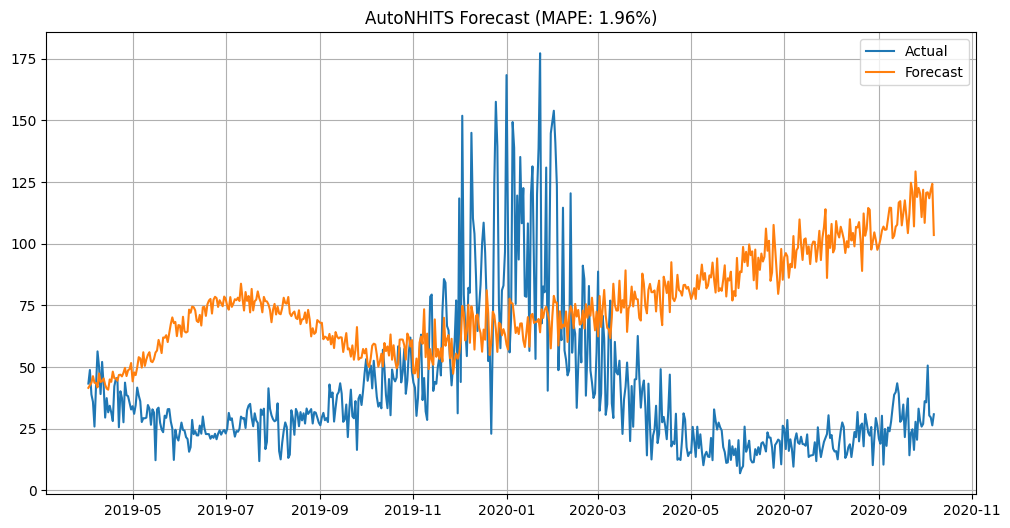

In [90]:
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Merge forecast with actuals
test_df_copy = test_df.copy()
test_df_copy['forecast'] = forecast_df
score = mean_absolute_percentage_error(test_df_copy['y'], test_df_copy['forecast'])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_df_copy['ds'], test_df_copy['y'], label="Actual")
plt.plot(test_df_copy['ds'], test_df_copy['forecast'], label="Forecast")
plt.title(f'AutoNHITS Forecast (MAPE: {score:.2f}%)')
plt.legend()
plt.grid(True)
plt.show()


Predicting: |          | 0/? [00:00<?, ?it/s]

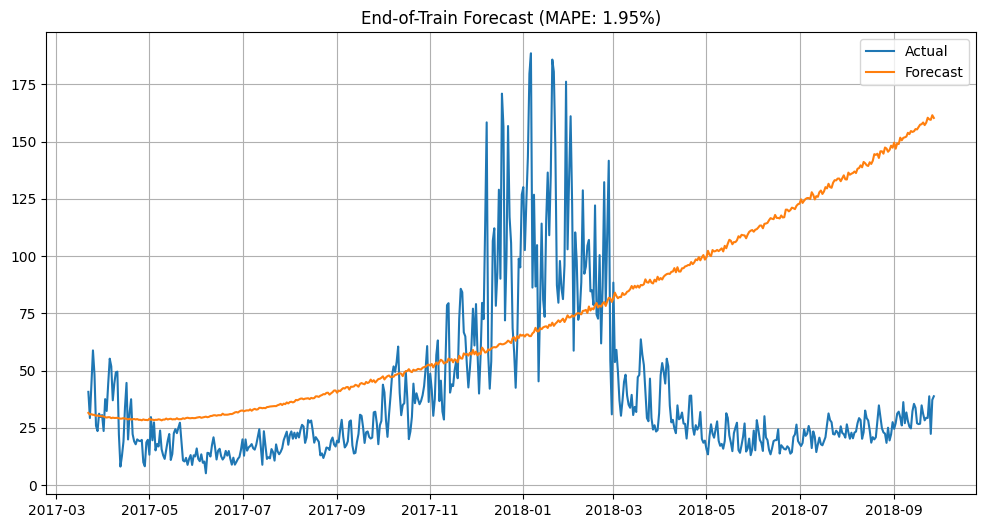

In [91]:
train_tail = train_df[:h]  # compare to predicted values
forecast_train_tail = model.predict(dataset=train_dataset[0])

# Merge and plot
train_tail = train_tail.copy()
train_tail['forecast'] = forecast_train_tail

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_tail['ds'], train_tail['y'], label="Actual")
plt.plot(train_tail['ds'], train_tail['forecast'], label="Forecast")
plt.title(f'End-of-Train Forecast (MAPE: {mean_absolute_percentage_error(train_tail["y"], train_tail["forecast"]):.2f}%)')
plt.legend()
plt.grid(True)
plt.show()
